Adapted from https://github.com/PacktPublishing/Python-Image-Processing-Cookbook

In [0]:
import torch
from torchvision import models, transforms
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pylab as plt
from torchvision import models, transforms
import requests
from io import BytesIO
from IPython.display import display

In [0]:
!git clone https://github.com/PacktPublishing/Python-Image-Processing-Cookbook.git

Cloning into 'Python-Image-Processing-Cookbook'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 2642 (delta 24), reused 28 (delta 11), pack-reused 2592
Receiving objects: 100% (2642/2642), 1.25 GiB | 15.77 MiB/s, done.
Resolving deltas: 100% (493/493), done.
Checking out files: 100% (1078/1078), done.


In [0]:
DATA_DIR = '/content/Python-Image-Processing-Cookbook/Chapter 07/'
IMAGE_DIR = DATA_DIR + 'images/'

In [0]:
def classify(img, model_index, model_name, model_pred, labels):
    #print(model_name, model_pred.shape)
    _, index = torch.max(model_pred, 1)
    model_pred, indices = torch.sort(model_pred, dim=1, descending=True)
    percentage = torch.nn.functional.softmax(model_pred, dim=1)[0] * 100
    print(labels[index[0]], percentage[0].item())
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf", 50, encoding="unic")
    draw.text((5, 5+model_index*50),'{}, pred: {},{}%'.format(model_name, labels[index[0]], round(percentage[0].item(),2)),(255,0,0),font=font)
    return indices, percentage

    


In [0]:
def classify_vgg16(img):
  img = img.convert('RGB')
  img_t = transform(img)
  batch_t = torch.unsqueeze(img_t,0)

  vgg16 = models.vgg16(pretrained=True)
  vgg16.eval()
  pred = vgg16(batch_t)
  indices, percentages = classify(img, 0,'vgg16',pred,labels)

  plt.figure(figsize=(20,10))
  plt.subplot(121), plt.imshow(img), plt.axis('off'), plt.title('image classified with pytorch', size=20)
  plt.subplot(122), plt.bar(range(5), percentages.detach().numpy()[:5], align='center', alpha=0.5)
  #print(indices[0].detach().numpy()[:5])
  plt.xticks(range(5),  np.array(labels)[indices.detach().numpy().astype(int)[0][:5]])
  plt.xlabel('predicted labels', size=20), plt.ylabel('predicted percentage', size=20)
  plt.title('Resnet top 5 classes predicted', size=20)
  plt.show()

In [0]:
transform = transforms.Compose([            
 transforms.Resize(256),                    
 transforms.CenterCrop(224),                
 transforms.ToTensor(),                     
 transforms.Normalize(                      
 mean=[0.485, 0.456, 0.406],                
 std=[0.229, 0.224, 0.225]                  
 )])                

In [0]:
print(dir(models))

['AlexNet', 'DenseNet', 'GoogLeNet', 'GoogLeNetOutputs', 'Inception3', 'InceptionOutputs', 'MNASNet', 'MobileNetV2', 'ResNet', 'ShuffleNetV2', 'SqueezeNet', 'VGG', '_GoogLeNetOutputs', '_InceptionOutputs', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_utils', 'alexnet', 'densenet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'detection', 'googlenet', 'inception', 'inception_v3', 'mnasnet', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet', 'mobilenet_v2', 'quantization', 'resnet', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext50_32x4d', 'segmentation', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'shufflenetv2', 'squeezenet', 'squeezenet1_0', 'squeezenet1_1', 'utils', 'vgg', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn', 'video', 'wide_resnet101_2', 'wide_r

In [0]:
with open(DATA_DIR + 'models/imagenet_classes.txt') as f:
    labels = [line.strip() for line in f.readlines()]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



cheetah 99.92057800292969


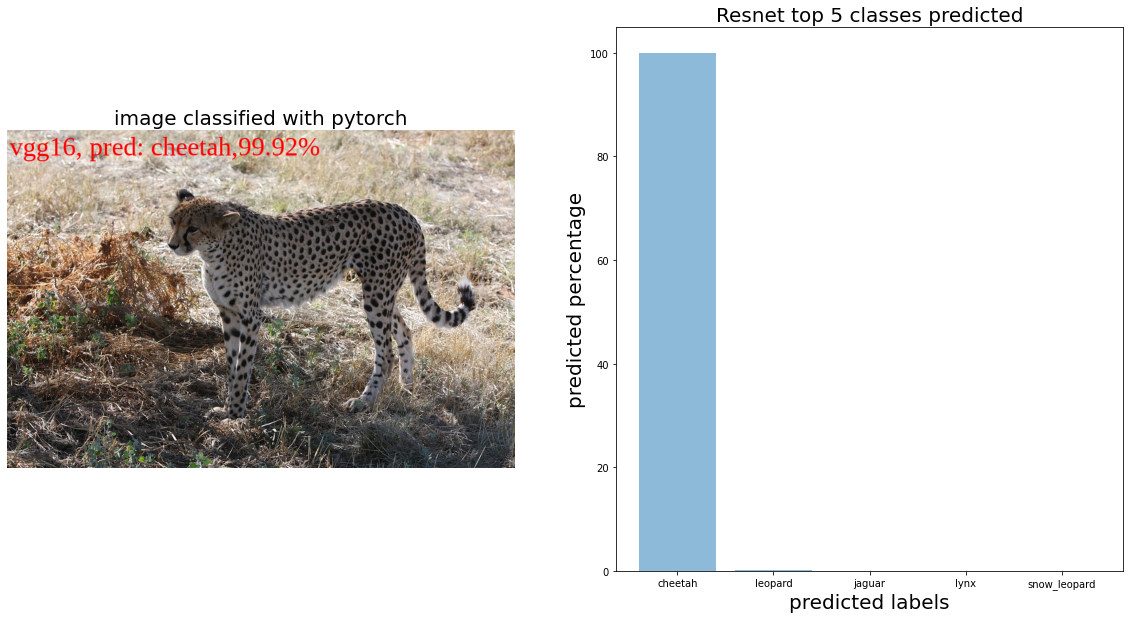

In [0]:
imgfile = IMAGE_DIR + 'cheetah.png'
img = Image.open(imgfile)
classify_vgg16(img)

In [0]:
image_url = 'https://static.scientificamerican.com/sciam/cache/file/0797818C-6C4D-43BD-B6A06E1E68E033E9_source.png'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))

starfish 21.570755004882812


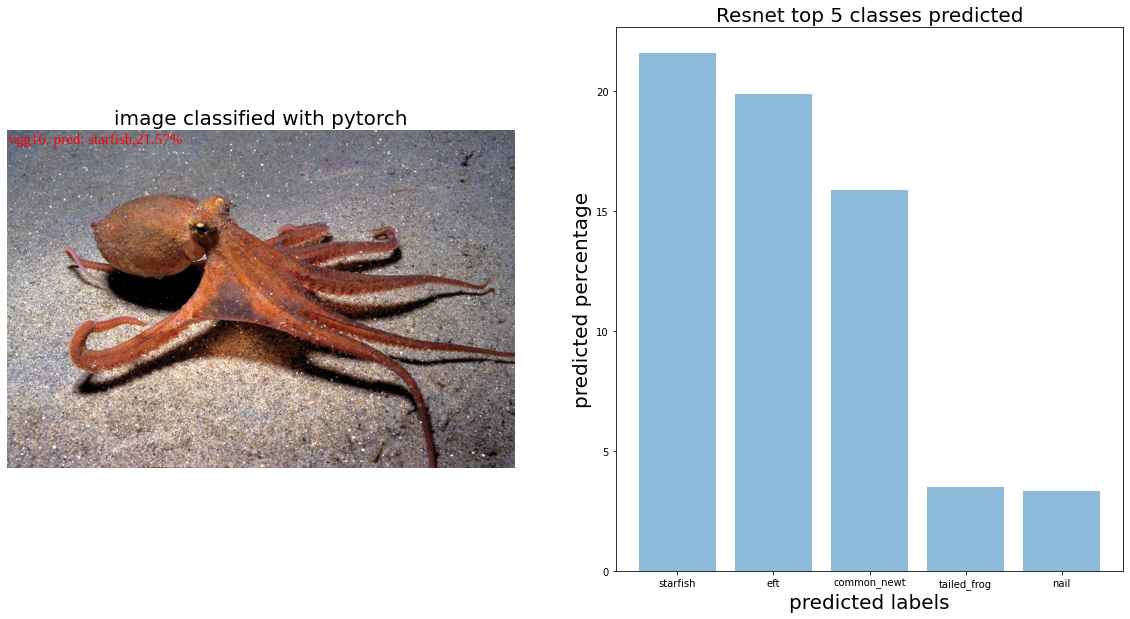

In [0]:
classify_vgg16(img)

## **Image Classification with Fine Tuning + Transfer Learning**

In [0]:
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import load_img
import matplotlib.pylab as plt
import numpy as np
import os
import shutil
import pandas as pd
import glob
import re

Using TensorFlow backend.


In [0]:
from keras import models
from keras import layers
from keras import optimizers
from keras.utils.vis_utils import plot_model

In [0]:
import tensorflow as tf
import tensorflow_hub as hub

In [0]:
!rm flower_photos.tgz*
!wget http://download.tensorflow.org/example_images/flower_photos.tgz

rm: cannot remove 'flower_photos.tgz*': No such file or directory
--2020-05-31 06:48:46--  http://download.tensorflow.org/example_images/flower_photos.tgz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.212.128, 2607:f8b0:4001:c03::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.212.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   129MB/s    in 1.7s    

2020-05-31 06:48:48 (129 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [0]:
!rm -rf flower_photos
!tar xzvf flower_photos.tgz

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

In [0]:
image_category_df = pd.DataFrame([[re.search('/content/flower_photos/(.*)/',filename).group(1),filename] \
              for filename in glob.glob('/content/flower_photos/*/*.jpg')],columns=['category','path'])

In [0]:
pd.DataFrame(image_category_df.groupby('category').count()).reset_index()

category  path
0       daisy   633
1   dandelion   898
2       roses   641
3  sunflowers   699
4      tulips   799

In [0]:
train_df_list,valid_df_list,test_df_list = [],[],[]
for df_row in image_category_df[['category']].drop_duplicates().itertuples():

  image_1category_df = image_category_df[image_category_df.category==df_row.category]
  train, validate, test = np.split(image_1category_df.sample(frac=1), [int(.6*len(image_1category_df)), int(.8*len(image_1category_df))])

  train_df_list+=[train]
  valid_df_list+=[validate]
  test_df_list+=[test]

train_df = pd.concat(train_df_list)
valid_df = pd.concat(valid_df_list)
test_df = pd.concat(test_df_list)


In [0]:
len(train_df),len(valid_df),len(test_df)

(2199, 735, 736)

In [0]:
base_dir = '/content/flower_photos'
image_size = 299
train_batchsize = 100

In [0]:
for df_row in train_df.itertuples():
  if not os.path.exists(os.path.join(base_dir,'train',df_row.category)):
    os.makedirs(os.path.join(base_dir, 'train', df_row.category))
  shutil.move(df_row.path  , os.path.join(base_dir, 'train', df_row.category))


In [0]:
for df_row in valid_df.itertuples():
  if not os.path.exists(os.path.join(base_dir,'valid',df_row.category)):
    os.makedirs(os.path.join(base_dir, 'valid', df_row.category))
  shutil.move(df_row.path  , os.path.join(base_dir, 'valid', df_row.category))

In [0]:
for df_row in test_df.itertuples():
  if not os.path.exists(os.path.join(base_dir,'test',df_row.category)):
    os.makedirs(os.path.join(base_dir, 'test', df_row.category))
  shutil.move(df_row.path  , os.path.join(base_dir, 'test', df_row.category))

In [0]:
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir,'test')

In [0]:
image_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
valid_generator = image_datagen.flow_from_directory(
        valid_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

Found 735 images belonging to 5 classes.


In [0]:
test_generator = image_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

Found 736 images belonging to 5 classes.


In [0]:
for image_batch, label_batch in test_generator:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 299, 299, 3)
Label batch shape:  (32, 5)


In [0]:
classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/inception_v3/classification/4", output_shape=[1001])
])
classifier.build([None, 299, 299, 3])

In [0]:
result_batch = classifier.predict(image_batch)

In [0]:
result_batch.shape

(32, 1001)

In [0]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [0]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]

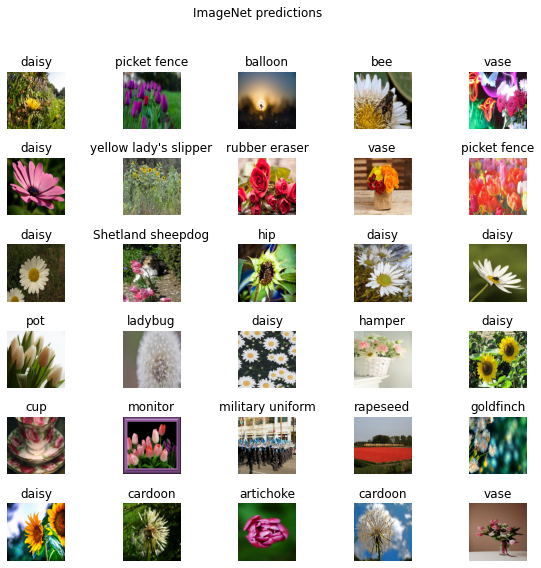

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
image_size = 224

#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
train_generator = image_datagen.flow_from_directory(
        train_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

Found 2199 images belonging to 5 classes.


In [0]:
!history

In [0]:
valid_generator = image_datagen.flow_from_directory(
        valid_dir,
        target_size=(image_size, image_size),
        batch_size=train_batchsize,
        class_mode='categorical')

Found 735 images belonging to 5 classes.


In [0]:
test_generator = image_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

Found 736 images belonging to 5 classes.


In [0]:
# Freeze all the conv layers except the last two
for layer in vgg_conv.layers[:-2]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7feb67d37f98> False
<keras.layers.convolutional.Conv2D object at 0x7feb67d37f28> False
<keras.layers.convolutional.Conv2D object at 0x7feb67d37cf8> False
<keras.layers.pooling.MaxPooling2D object at 0x7feb67eff0b8> False
<keras.layers.convolutional.Conv2D object at 0x7feb66f7e630> False
<keras.layers.convolutional.Conv2D object at 0x7feb66e7db38> False
<keras.layers.pooling.MaxPooling2D object at 0x7feb669f6668> False
<keras.layers.convolutional.Conv2D object at 0x7feb669f64a8> False
<keras.layers.convolutional.Conv2D object at 0x7feb669f6f98> False
<keras.layers.convolutional.Conv2D object at 0x7feb669fcd30> False
<keras.layers.pooling.MaxPooling2D object at 0x7feb669ff7b8> False
<keras.layers.convolutional.Conv2D object at 0x7feb669ff5f8> False
<keras.layers.convolutional.Conv2D object at 0x7feb66986320> False
<keras.layers.convolutional.Conv2D object at 0x7feb66986e80> False
<keras.layers.pooling.MaxPooling2D object at 0x7feb6698d908>

In [0]:
# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 5125      
Total params: 40,410,949
Trainable params: 28,056,069
Non-trainable params: 12,354,880
_________________________________________________________________


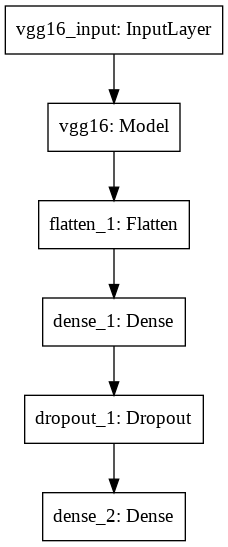

In [0]:
plot_model(model)

In [0]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [0]:
# Train the Model
history = model.fit_generator(
      train_generator,
      steps_per_epoch=train_generator.samples/train_generator.batch_size ,
      epochs=20,
      validation_data=valid_generator,
      validation_steps=valid_generator.samples/valid_generator.batch_size,
      verbose=1)

Epoch 1/20
22/21 [==============================] - 50s 2s/step - loss: 1.5496 - acc: 0.3588 - val_loss: 1.0005 - val_acc: 0.6585
Epoch 2/20
22/21 [==============================] - 29s 1s/step - loss: 1.0804 - acc: 0.5807 - val_loss: 0.6808 - val_acc: 0.6952
Epoch 3/20
22/21 [==============================] - 29s 1s/step - loss: 0.8555 - acc: 0.6812 - val_loss: 0.8044 - val_acc: 0.7293
Epoch 4/20
22/21 [==============================] - 29s 1s/step - loss: 0.6989 - acc: 0.7553 - val_loss: 0.4196 - val_acc: 0.7537
Epoch 5/20
22/21 [==============================] - 29s 1s/step - loss: 0.6087 - acc: 0.7990 - val_loss: 0.5525 - val_acc: 0.7755
Epoch 6/20
22/21 [==============================] - 29s 1s/step - loss: 0.5256 - acc: 0.8304 - val_loss: 0.4906 - val_acc: 0.7633
Epoch 7/20
22/21 [==============================] - 29s 1s/step - loss: 0.4477 - acc: 0.8658 - val_loss: 0.4650 - val_acc: 0.7796
Epoch 8/20
22/21 [==============================] - 29s 1s/step - loss: 0.4068 - acc: 0.87

In [0]:
# Save the Model
model.save('flowers_model.h5')

In [0]:
# Plot the accuracy and loss curves
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

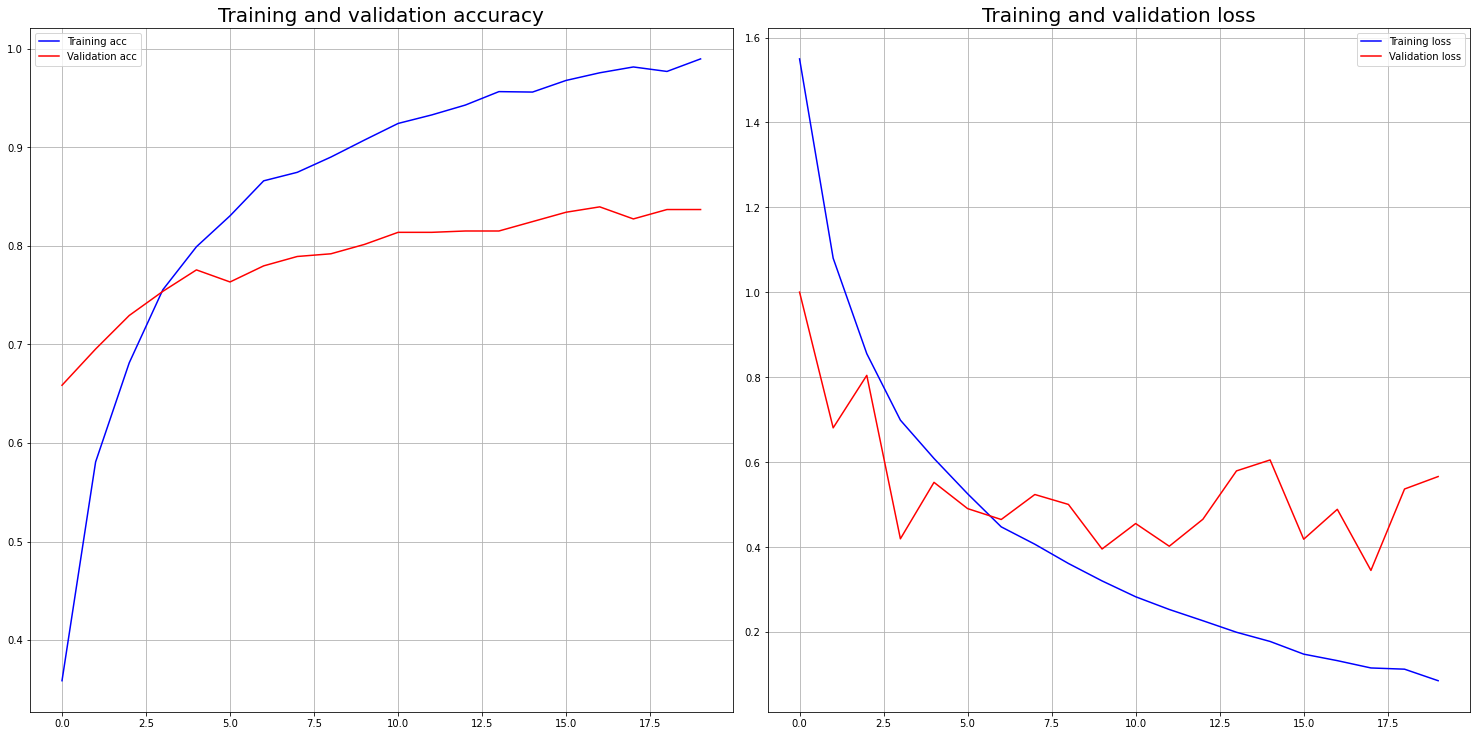

In [0]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0)
plt.subplot(121)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.legend(prop={'size': 10})
plt.grid()
plt.subplot(122)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.legend(prop={'size': 10})
plt.grid()
plt.show()

In [0]:
test_generator.reset()
for image_batch, label_batch in test_generator:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


In [0]:
result_batch = model.predict(image_batch)

In [0]:
# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
index2label = dict((v,k) for k,v in label2index.items())

In [0]:
predicted_classes = np.argmax(predictions,axis=-1)
predicted_class_names = np.array([index2label[k] for k in predicted_classes])

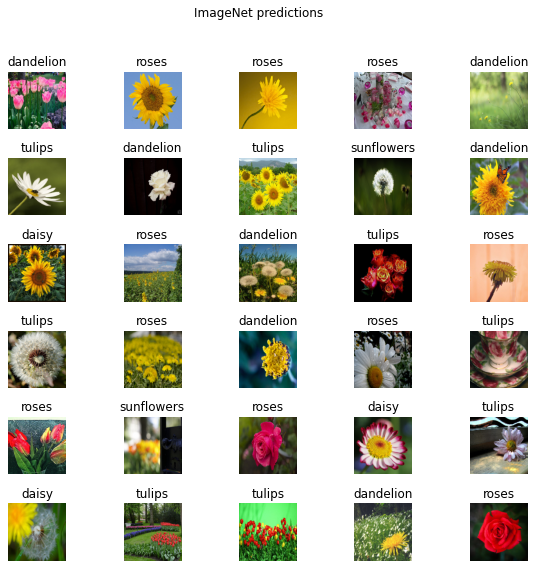

In [0]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [0]:
test_generator = image_datagen.flow_from_directory(
        test_dir,
        target_size=(image_size, image_size),
        batch_size=1,
        class_mode='categorical',
        shuffle=False)

Found 736 images belonging to 5 classes.


In [0]:
test_generator.reset()

# Get the filenames from the generator
fnames = test_generator.filenames

# Get the ground truth from generator
ground_truth = test_generator.classes

# Get the label to class mapping from the generator
label2index = test_generator.class_indices

# Getting the mapping from class index to class label
index2label = dict((v,k) for k,v in label2index.items())

# Get the predictions from the model using the generator
predictions = model.predict_generator(test_generator, steps=len(fnames))
predicted_classes = np.argmax(predictions,axis=-1)
predicted_classes = np.array([index2label[k] for k in predicted_classes])

In [0]:
ground_truth = np.array([index2label[k] for k in ground_truth])
errors = np.where(predicted_classes != ground_truth)[0]
print("No of errors = {}/{}".format(len(errors),test_generator.samples))

No of errors = 128/736


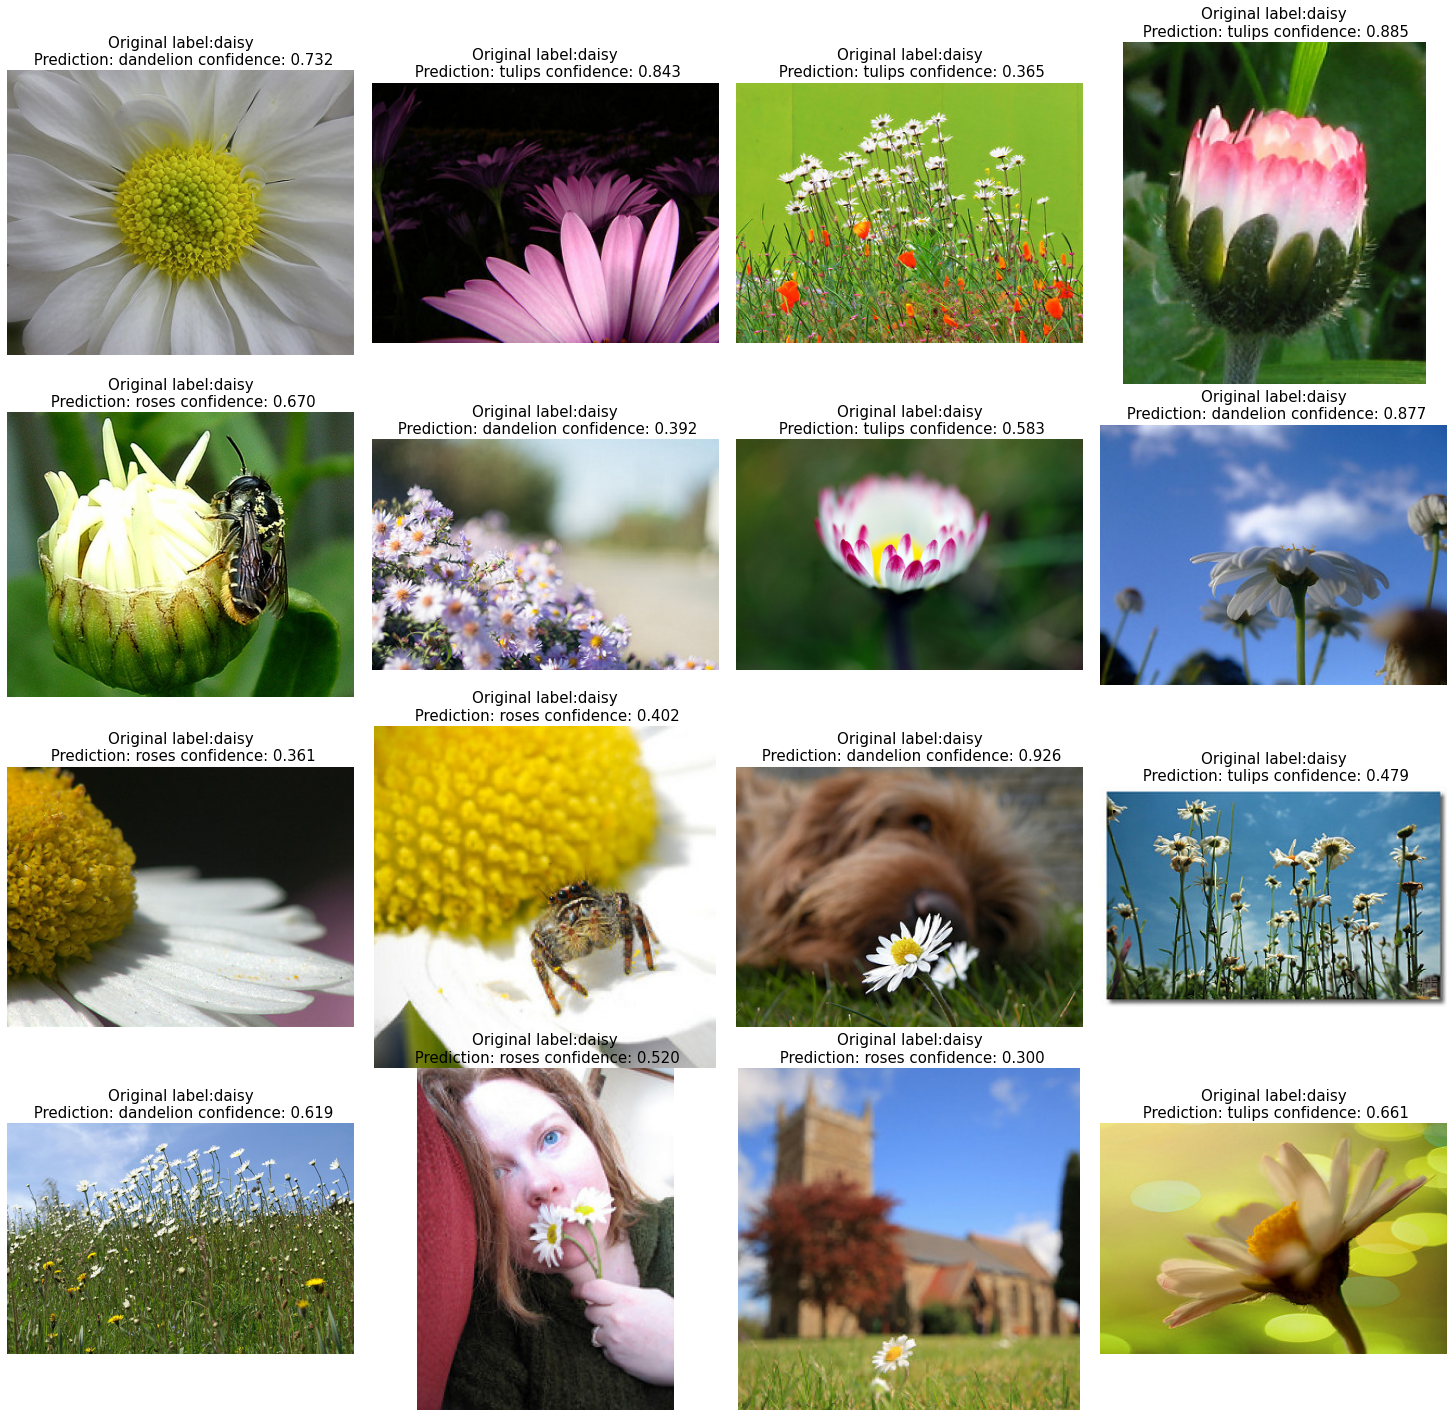

In [0]:
# Show the errors
plt.figure(figsize=[20,20])
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0)
for i in range(16):
    pred_label = predicted_classes[errors[i]]
    title = 'Original label:{}\n Prediction: {} confidence: {:.3f}'.format(
        ground_truth[errors[i]],
        pred_label,
        predictions[errors[i]][label2index[pred_label]], size=20)
    
    original = load_img('{}/{}'.format(test_dir,fnames[errors[i]]))
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.title(title, size=15)
    plt.imshow(original)
plt.show()

In [0]:
correct = np.where(predicted_classes == ground_truth)[0]

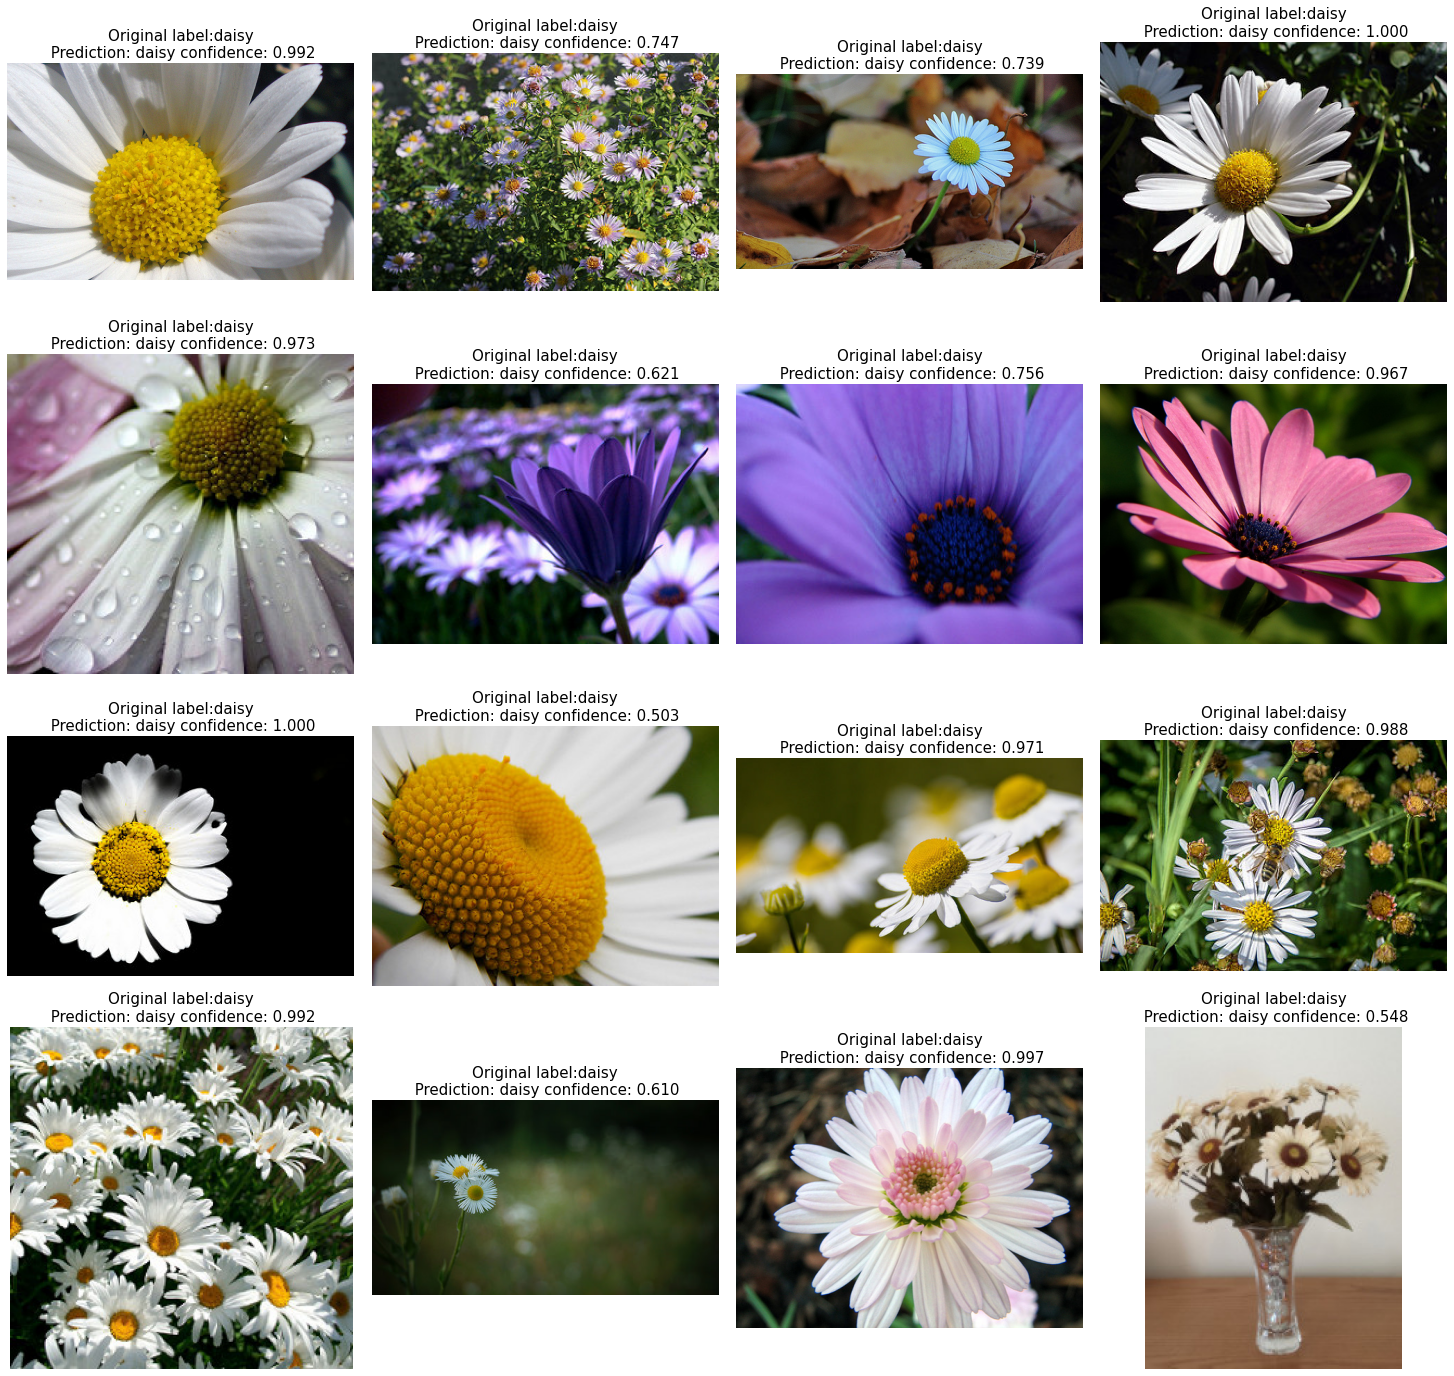

In [0]:
# Show the errors
plt.figure(figsize=[20,20])
plt.subplots_adjust(left=0, right=1, bottom=0, top=0.95, wspace=0.05, hspace=0)
for i in range(16):
    pred_label = predicted_classes[correct[i]]
    title = 'Original label:{}\n Prediction: {} confidence: {:.3f}'.format(
        ground_truth[correct[i]],
        pred_label,
        predictions[correct[i]][label2index[pred_label]], size=20)
    
    original = load_img('{}/{}'.format(test_dir,fnames[correct[i]]))
    plt.subplot(4,4,i+1)
    plt.axis('off')
    plt.title(title, size=15)
    plt.imshow(original)
plt.show()